In [1]:
from dotenv import load_dotenv
load_dotenv()

True

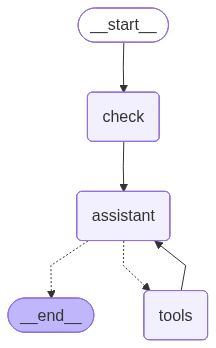

In [20]:
from langgraph.types import interrupt
from typing import TypedDict
from langchain_openai import ChatOpenAI
from IPython.display import Image, display
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

def tyre_strat(Laps_Remaining: int, Laps_Done: int, Safety_Car: bool, drivability: bool) -> str:
    """
    This is used to suggest if the Driver needs to Box and Change Tyres
    """
    if Laps_Done > 15:
        return "Box for New Hards"
    elif not drivability:
        return "Change Tyres"
    elif (Laps_Remaining < 15 and Safety_Car):
        return "Box for a set of Softs and time to Turn and Burn"
    else:
        return "Stay Out!! Stay Out!! Stay Out!!"

def Wet_Condition(Laps_Remaining: int, is_raining: bool, drivability: bool) -> str:
    """
    If there exists a wet condition use this
    """
    if drivability:
        return "Let's drive in until the brink of toughness"
    elif is_raining and (not drivability):
        return "Box for Wets and Unleash Hell"
    elif Laps_Remaining < 5:
        return "Let's nurse this car back home, Pit Stop is not worth the time gain"
    else:
        return "Stay Out!! Stay Out!! Stay Out!!"

# Initialize the model and bind the tools
tools = [tyre_strat, Wet_Condition]
llm = ChatOpenAI(model="gpt-4o")
llm_with_tools = llm.bind_tools(tools)


sys_msg = SystemMessage(content="You are a F1 Race Engineer. Help the driver make strategic decisions.")

# Define the nodes for the graph
def check_input(state: MessagesState):
    last_message = state['messages'][-1]

    if len(last_message.content) > 40:
        raise interrupt(f"Message is too long for the radio! Keep it short. Received: '{last_message.content}'")
    return state

def assistant(state: MessagesState):
    messages_with_system = [sys_msg] + state["messages"]
    response = llm_with_tools.invoke(messages_with_system)
    return {"messages": [response]}

tool_node = ToolNode(tools)

builder = StateGraph(MessagesState)

builder.add_node("check", check_input)
builder.add_node("assistant", assistant)
builder.add_node("tools", tool_node)

builder.add_edge(START, "check")
builder.add_edge("check", "assistant")
builder.add_conditional_edges("assistant", tools_condition)
builder.add_edge("tools", "assistant")

memory = MemorySaver()

graph = builder.compile(checkpointer=memory)


display(Image(graph.get_graph(xray=True).draw_mermaid_png()))


In [38]:
thread = {"configurable": {"thread_id": "Driver_8"}}


initial_input = {"messages": [HumanMessage(content="The Car is driving all around the road and it is raining like crazy and what is the plan to box me or Piastri")]}

for event in graph.stream(initial_input, thread, stream_mode="values"):
    print(event)



{'messages': [HumanMessage(content='The Car is driving all around the road and it is raining like crazy and what is the plan to box me or Piastri', additional_kwargs={}, response_metadata={}, id='044341b6-7780-4800-847a-c96d1035c415')]}
{'__interrupt__': (Interrupt(value="Message is too long for the radio! Keep it short. Received: 'The Car is driving all around the road and it is raining like crazy and what is the plan to box me or Piastri'", id='c036196e28cf2dcfdcd5b87d881e6578'),)}


In [39]:

graph.update_state(
    thread,
    {"messages": [HumanMessage(content="Car is undrivable,losing grip from Rain")]},
)


for event in graph.stream(None, thread, stream_mode="values"):
    # Print the latest message from the assistant or tools
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Car is undrivable,losing grip from Rain
================================ Human Message =================================

Car is undrivable,losing grip from Rain
================================== Ai Message ==================================
Tool Calls:
  Wet_Condition (call_hCpD8C0yX3H9EOBsbFjo11hz)
 Call ID: call_hCpD8C0yX3H9EOBsbFjo11hz
  Args:
    Laps_Remaining: 15
    is_raining: True
    drivability: False
================================= Tool Message =================================
Name: Wet_Condition

Box for Wets and Unleash Hell
================================== Ai Message ==================================

Box for wet tires and then push hard!


In [40]:
for event in graph.stream(None, thread, stream_mode="values"):
    # Print the latest message from the assistant or tools
    event['messages'][-1].pretty_print()

================================== Ai Message ==================================

Box for wet tires and then push hard!
